# Train on real data - Transfer Learning

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model
from keras import optimizers

from utils import *
import config

Using TensorFlow backend.


In [2]:
STUDY_PATH = config.STUDY_PATH
REAL_FILE = config.REAL_FILE

TRAIN_VAL_RATIO = config.TRAIN_VAL_RATIO
N_STEPS = config.N_STEPS
N_FEATURES_IN = config.N_FEATURES_IN
N_FEATURES_OUT = config.N_FEATURES_OUT
MODEL_NAME = config.MODEL_NAME

In [3]:
model_path = f'{STUDY_PATH}/{MODEL_NAME}.hdf'

In [4]:
err_upper_limit = 14
pd.options.display.max_columns = 25

with open('features.json') as infile:
    n_epochs, lr = json.load(infile).values()
    
n_epochs, lr

(1300, 0.0001)

In [5]:
df = pd.read_csv(f"{REAL_FILE}")

out_names = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
outputs = df[out_names]
inputs = df.drop(columns=out_names, axis=1)

In [6]:
all_len = len(inputs)
train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
n_input = N_STEPS * N_FEATURES_IN

train_len, all_len

(396, 496)

In [7]:
# split a multivariate sequence into samples 
raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
true_data = np.hstack((inputs, outputs)) # ins and outs - all

# normalize the data
scaler = MinMaxScaler()
raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
true_data_norm = scaler.transform(true_data)

X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)

X.shape, y.shape, X_all.shape

((391, 5, 6), (391, 3), (491, 5, 6))

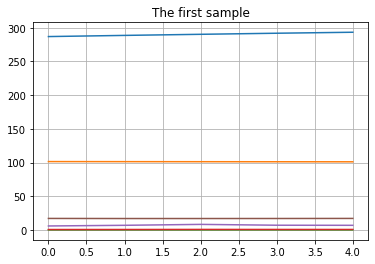

In [8]:
# plot the first sample 

plt.figure(figsize=(6, 4))
plt.plot(raw_seq1[:N_STEPS, :N_FEATURES_IN])
plt.title("The first sample")
plt.grid(True)
plt.show();

In [9]:
# load model
if MODEL_NAME == 'MLP':
    model = load_model(model_path)
    
    for layer in model.layers[:-1]:
        layer.trainable = False
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    
    # flatten input
    X_reshaped = X.reshape((X.shape[0], n_input))
    X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    
elif MODEL_NAME == 'LSTM':
    model = load_model(model_path)
    
    for layer in model.layers[:-1]:
        layer.trainable = False
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    
    X_reshaped = X
    X_all_reshaped = X_all
    
elif MODEL_NAME == 'TCN':
    import tensorflow.keras.optimizers

    loaded_json = open(f'{model_path[:-4]}.json', 'r').read()
    reloaded_model = model_from_json(loaded_json, custom_objects={'TCN': TCN})
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    
    X_reshaped = X
    X_all_reshaped = X_all

elif MODEL_NAME == "XGB":
    model = pickle.load(open(model_path, "rb"))
    
    X_reshaped = X.reshape((X.shape[0], n_input))
    X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))

In [10]:
# train the model
start_time = time.time()

if MODEL_NAME == 'TCN':
    model_inf = model.fit(X_reshaped, y, epochs=n_epochs, verbose=1)
elif MODEL_NAME == 'XGB':
    model.fit(X_reshaped, y)
else:
    model_inf = model.fit(X_reshaped, y, epochs=n_epochs, verbose=1, batch_size=32)

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Epoch 1/1300
391/391 [==============================] - 0s 440us/step - loss: 0.5244
Epoch 2/1300
391/391 [==============================] - 0s 33us/step - loss: 0.5056
Epoch 3/1300
391/391 [==============================] - 0s 31us/step - loss: 0.5026
Epoch 4/1300
391/391 [==============================] - 0s 33us/step - loss: 0.5001
Epoch 5/1300
391/391 [==============================] - 0s 36us/step - loss: 0.4800
Epoch 6/1300
391/391 [==============================] - 0s 38us/step - loss: 0.4667
Epoch 7/1300
391/391 [==============================] - 0s 36us/step - loss: 0.4641
Epoch 8/1300
391/391 [==============================] - 0s 33us/step - loss: 0.4506
Epoch 9/1300
391/391 [==============================] - 0s 31us/step - loss: 0.4439
Epoch 10/1300
391/391 [==============================] - 0s 33us/step - loss: 0.4348
Epoch 11/1300
391/391 [==============================] - 0s 33us/step - loss: 0.4291
Epoch 12/1300
391/391 [==============================] - 0s 36us/step - l

391/391 [==============================] - 0s 41us/step - loss: 0.0990
Epoch 97/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0941
Epoch 98/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0954
Epoch 99/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0922
Epoch 100/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0953
Epoch 101/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0973
Epoch 102/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0909
Epoch 103/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0915
Epoch 104/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0897
Epoch 105/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0876
Epoch 106/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0918
Epoch 107/1300
391/391 [==============================] - 0s 36us/step -

391/391 [==============================] - 0s 38us/step - loss: 0.0724
Epoch 192/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0696
Epoch 193/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0727
Epoch 194/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0714
Epoch 195/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0708
Epoch 196/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0679
Epoch 197/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0699
Epoch 198/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0671
Epoch 199/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0717
Epoch 200/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0716
Epoch 201/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0681
Epoch 202/1300
391/391 [==============================] - ETA: 0s - l

391/391 [==============================] - 0s 38us/step - loss: 0.0652
Epoch 286/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0653
Epoch 287/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0669
Epoch 288/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0652
Epoch 289/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0616
Epoch 290/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0627
Epoch 291/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0630
Epoch 292/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0613
Epoch 293/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0665
Epoch 294/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0623
Epoch 295/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0641
Epoch 296/1300
391/391 [==============================] - 0s 36us/ste

391/391 [==============================] - 0s 43us/step - loss: 0.0583
Epoch 381/1300
391/391 [==============================] - 0s 46us/step - loss: 0.0593
Epoch 382/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0585
Epoch 383/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0591
Epoch 384/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0593
Epoch 385/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0581
Epoch 386/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0593
Epoch 387/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0554
Epoch 388/1300
391/391 [==============================] - 0s 37us/step - loss: 0.0585
Epoch 389/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0572
Epoch 390/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0591
Epoch 391/1300
391/391 [==============================] - 0s 41us/ste

391/391 [==============================] - 0s 41us/step - loss: 0.0541
Epoch 476/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0517
Epoch 477/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0544
Epoch 478/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0532
Epoch 479/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0550
Epoch 480/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0535
Epoch 481/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0529
Epoch 482/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0527
Epoch 483/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0536
Epoch 484/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0514
Epoch 485/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0539
Epoch 486/1300
391/391 [==============================] - 0s 41us/ste

391/391 [==============================] - 0s 38us/step - loss: 0.0488
Epoch 571/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0506
Epoch 572/1300
391/391 [==============================] - 0s 48us/step - loss: 0.0492
Epoch 573/1300
391/391 [==============================] - 0s 48us/step - loss: 0.0506
Epoch 574/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0501
Epoch 575/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0491
Epoch 576/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0499
Epoch 577/1300
391/391 [==============================] - 0s 46us/step - loss: 0.0495
Epoch 578/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0482
Epoch 579/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0503
Epoch 580/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0499
Epoch 581/1300
391/391 [==============================] - 0s 33us/ste

391/391 [==============================] - 0s 33us/step - loss: 0.0481
Epoch 666/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0463
Epoch 667/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0465
Epoch 668/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0466
Epoch 669/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0473
Epoch 670/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0474
Epoch 671/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0454
Epoch 672/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0471
Epoch 673/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0449
Epoch 674/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0461
Epoch 675/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0462
Epoch 676/1300
391/391 [==============================] - 0s 36us/ste

391/391 [==============================] - 0s 36us/step - loss: 0.0449
Epoch 761/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0440
Epoch 762/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0446
Epoch 763/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0443
Epoch 764/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0438
Epoch 765/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0446
Epoch 766/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0445
Epoch 767/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0434
Epoch 768/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0453
Epoch 769/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0440
Epoch 770/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0450
Epoch 771/1300
391/391 [==============================] - 0s 46us/ste

391/391 [==============================] - 0s 33us/step - loss: 0.0438
Epoch 856/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0445
Epoch 857/1300
391/391 [==============================] - 0s 28us/step - loss: 0.0432
Epoch 858/1300
391/391 [==============================] - 0s 48us/step - loss: 0.0427
Epoch 859/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0429
Epoch 860/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0456
Epoch 861/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0414
Epoch 862/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0433
Epoch 863/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0425
Epoch 864/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0423
Epoch 865/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0437
Epoch 866/1300
391/391 [==============================] - 0s 36us/ste

391/391 [==============================] - 0s 33us/step - loss: 0.0410
Epoch 951/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0424
Epoch 952/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0426
Epoch 953/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0437
Epoch 954/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0427
Epoch 955/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0426
Epoch 956/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0410
Epoch 957/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0414
Epoch 958/1300
391/391 [==============================] - 0s 43us/step - loss: 0.0426
Epoch 959/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0413
Epoch 960/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0433
Epoch 961/1300
391/391 [==============================] - 0s 31us/ste

391/391 [==============================] - 0s 41us/step - loss: 0.0416
Epoch 1045/1300
391/391 [==============================] - 0s 41us/step - loss: 0.0407
Epoch 1046/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0416
Epoch 1047/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0411
Epoch 1048/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0421
Epoch 1049/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0403
Epoch 1050/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0391
Epoch 1051/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0421
Epoch 1052/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0427
Epoch 1053/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0419
Epoch 1054/1300
391/391 [==============================] - 0s 34us/step - loss: 0.0422
Epoch 1055/1300
391/391 [==============================] - 

391/391 [==============================] - 0s 31us/step - loss: 0.0391
Epoch 1139/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0399
Epoch 1140/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0400
Epoch 1141/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0403
Epoch 1142/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0391
Epoch 1143/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0393
Epoch 1144/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0400
Epoch 1145/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0401
Epoch 1146/1300
391/391 [==============================] - 0s 31us/step - loss: 0.0426
Epoch 1147/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0401
Epoch 1148/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0415
Epoch 1149/1300
391/391 [==============================] - 

391/391 [==============================] - 0s 38us/step - loss: 0.0399
Epoch 1233/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0393
Epoch 1234/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0394
Epoch 1235/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0401
Epoch 1236/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0401
Epoch 1237/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0398
Epoch 1238/1300
391/391 [==============================] - 0s 38us/step - loss: 0.0394
Epoch 1239/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0392
Epoch 1240/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0397
Epoch 1241/1300
391/391 [==============================] - 0s 33us/step - loss: 0.0404
Epoch 1242/1300
391/391 [==============================] - 0s 36us/step - loss: 0.0402
Epoch 1243/1300
391/391 [==============================] - 

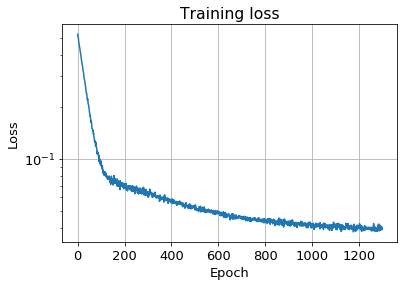

Model name:       MLP
Training time:    20.233 sec
Train error:      14.538
Test error:       12.240


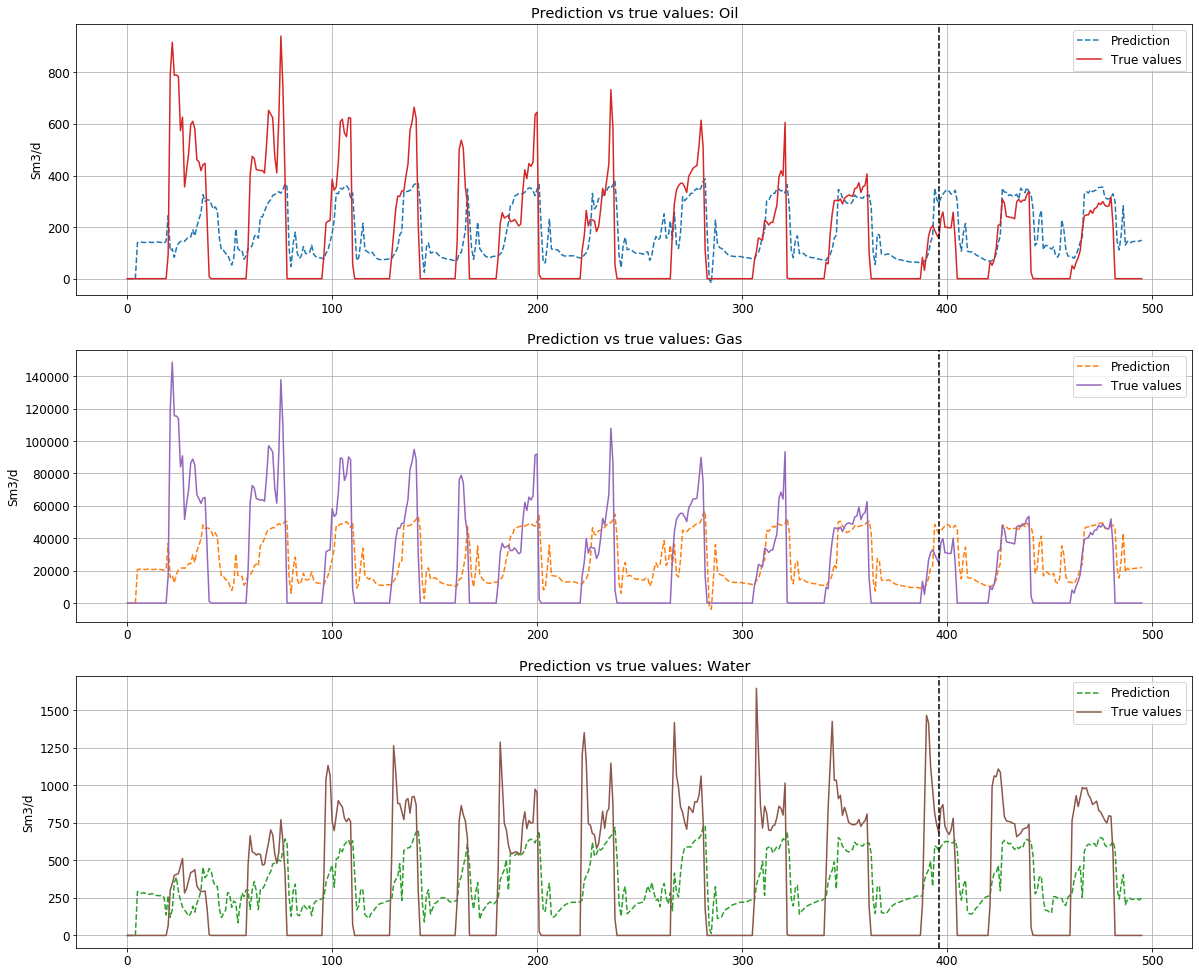

In [11]:
# obtain the model results: make a prediction and calculate an error

y_pred_norm = model.predict(X_all_reshaped)
table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
table = scaler.inverse_transform(table_norm) # denormalize all
preds = table[:, -N_FEATURES_OUT:]
errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

data = {}
data["model_name"] = MODEL_NAME
data["loss"] = model_inf.history['loss'] if MODEL_NAME != 'XGB' else ''
data["train_size"] = train_len
data["preds"] = preds.tolist()
data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
data["errors"] = errs.tolist()
data["training_time"] = delta_time
data["cur_time"] = str(cur_time)

if MODEL_NAME != 'XGB':
    plot_loss(data)
print_results(data)
plot_pred(data)
# plot_err(data)

### Save the tuned model

In [12]:
if MODEL_NAME == 'XGB':
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}-transf.hdf', "wb"))
elif MODEL_NAME == 'TCN':
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}-transf.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}-transf.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}-transf.hdf')